In [1]:
import pandas as pd

# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [2]:
import pandas as pd

# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [3]:
# 금속 농도 열 추출 (단위가 ng/m3인 열)
metal_columns = [col for col in df.columns if '(ng/m3)' in col]

# 날짜 및 시간 추출
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])
df['Date'] = df['Pump-Begin'].dt.date
df['Hour'] = df['Pump-Begin'].dt.hour

In [4]:
# 이상치 제거 (NaN, 음수, 0은 결측 처리)
for col in metal_columns:
    df[col] = df[col].apply(lambda x: x if pd.notna(x) and x > 0 else pd.NA)

In [5]:
# 분석기간 - 전체 데이터 사용
df_filtered = df.copy()

In [6]:
# Day/Night 분류 - TimePeriod 열 추가
def classify_time(hour):
    return 'Day' if 7 <= hour < 19 else 'Night'

df_filtered['TimePeriod'] = df_filtered['Hour'].apply(classify_time)

# 시간대 분류 결과 출력
df_filtered[['Pump-Begin', 'Hour', 'TimePeriod']].head(13)

,Pump-Begin,Hour,TimePeriod
0,2025-01-10 10:53:43,10,Day
1,2025-01-10 12:00:00,12,Day
2,2025-01-10 13:00:00,13,Day
3,2025-01-10 14:00:01,14,Day
4,2025-01-10 15:00:00,15,Day
5,2025-01-10 16:00:00,16,Day
6,2025-01-10 17:00:00,17,Day
7,2025-01-10 18:00:01,18,Day
8,2025-01-10 19:00:00,19,Night
9,2025-01-10 20:00:01,20,Night


In [7]:
# Total/Day/Night별 평균 금속농도 계산

# 하루 전체 평균(Total)
avg_total = df_filtered.groupby('Date')[metal_columns].mean().reset_index()
avg_total['TimePeriod'] = 'Total' # 하루 전체 평균 표시용

# 시간대별 평균(Day/Night)
avg_dn = df_filtered[df_filtered['TimePeriod'].isin(['Day', 'Night'])] \
            .groupby(['Date', 'TimePeriod'])[metal_columns] \
            .mean().reset_index()

# Total/Day/Night 평균 모두 결합
df_avg_all = pd.concat([avg_total, avg_dn], axis=0).sort_values(['Date', 'TimePeriod']).reset_index(drop=True)

# 결과 출력
df_avg_all.head(6)

,Date,Al(ng/m3),Si(ng/m3),S(ng/m3),K(ng/m3),Ca(ng/m3),Ti(ng/m3),V(ng/m3),Cr(ng/m3),Mn(ng/m3),...,In(ng/m3),Sn(ng/m3),Sb(ng/m3),Te(ng/m3),Cs(ng/m3),Ba(ng/m3),Ce(ng/m3),Pb(ng/m3),Bi(ng/m3),TimePeriod
0,2025-01-10,590.425714,742.2,1901.52,272.238571,134.777143,0.456667,4.187143,6.062857,9.427143,...,63.874286,21.965714,30.666667,22.374286,0.28,NaN,2.3,8.684286,6.984286,Day
1,2025-01-10,466.94,786.808,2663.986,252.816,121.178,0.544,4.244,6.172,9.454,...,47.15,20.306,21.154,19.654,NaN,7.5,0.8125,4.386,5.496,Night
2,2025-01-10,538.973333,760.786667,2219.214167,264.145833,129.110833,0.496364,4.210833,6.108333,9.438333,...,56.905833,21.274167,26.342727,21.240833,0.28,7.5,1.11,6.893333,6.364167,Total
3,2025-01-11,451.509167,750.3625,3805.734167,222.6675,111.0525,0.52125,3.6375,4.621667,9.335833,...,46.165833,16.5125,22.041818,26.124,0.26,7.76,2.576,5.596,5.170833,Day
4,2025-01-11,452.5975,745.466667,3515.835,243.815,113.508333,0.448333,4.993333,4.996667,8.049167,...,47.876667,21.813636,21.558,23.9975,NaN,NaN,6.038889,6.3875,5.085833,Night
5,2025-01-11,452.053333,747.914583,3660.784583,233.24125,112.280417,0.49,4.315417,4.809167,8.6925,...,47.02125,19.047826,21.811429,24.964091,0.26,7.76,4.802143,6.027727,5.128333,Total


In [8]:
# Total 데이터 추출
df_total = df_avg_all[df_avg_all['TimePeriod'] == 'Total'].copy()

<Figure size 1000x600 with 0 Axes>

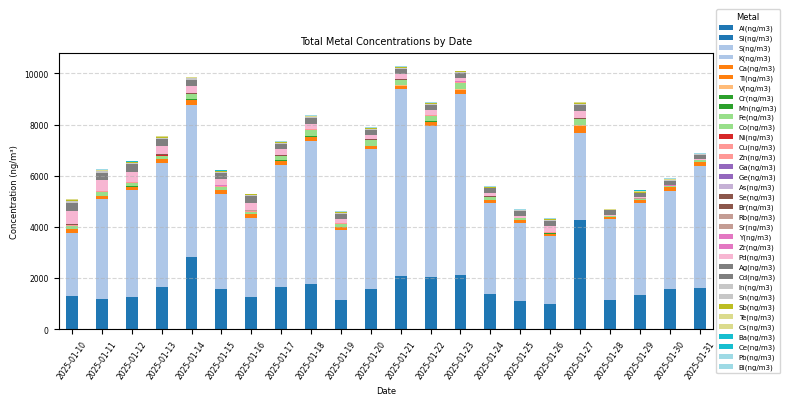

In [25]:
import matplotlib.pyplot as plt

# Total 누적 막대 그래프
plt.figure(figsize=(10,6)) # 전체 그래프 크기 설정

df_total.set_index('Date')[metal_columns].plot(
    kind='bar', # 막대 그래프
    stacked=True, # 누적 그래프 설정
    figsize=(8, 4),
    width=0.4, # 막대 너비 설정
    colormap='tab20') # 컬러맵 설정

# 그래프 기본 설정
plt.title("Total Metal Concentrations by Date", fontsize=7)
plt.xlabel("Date", fontsize=6)
plt.ylabel("Concentration (ng/m³)", fontsize=6)
plt.xticks(rotation=55, fontsize=5.5)
plt.yticks(fontsize=5.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 범례 설정
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5),
           fontsize=5,
           title='Metal',
           title_fontsize=6)

# 레이아웃 자동 조절
plt.tight_layout()

# 결과 출력
plt.show()

In [18]:
# Daytime 데이터 추출
df_day = df_avg_all[df_avg_all['TimePeriod'] == 'Day'].copy()

<Figure size 1000x600 with 0 Axes>

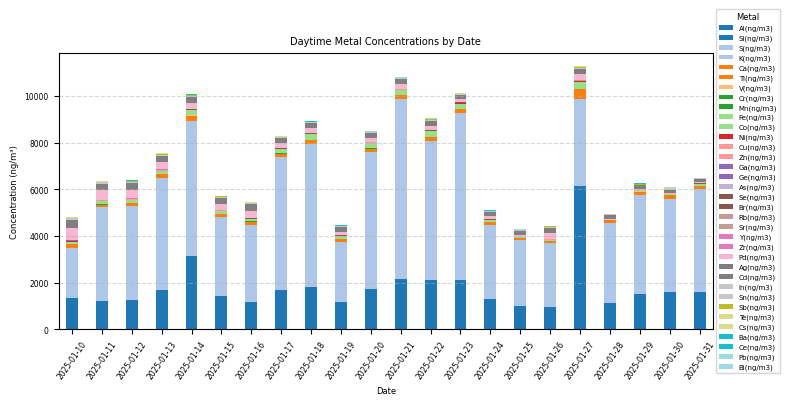

In [24]:
# Daytime 누적 막대 그래프
plt.figure(figsize=(10, 6))  # 전체 그래프 크기 설정

df_day.set_index('Date')[metal_columns].plot(
    kind='bar', # 막대 그래프
    stacked=True, # 누적 그래프 설정
    figsize=(8, 4),
    width=0.4, # 막대 너비 설정
    colormap='tab20') # 컬러맵 설정

# 그래프 기본 설정
plt.title("Daytime Metal Concentrations by Date", fontsize=7)
plt.xlabel("Date", fontsize=6)
plt.ylabel("Concentration (ng/m³)", fontsize=6)
plt.xticks(rotation=55, fontsize=5.5)
plt.yticks(fontsize=5.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 범례 설정
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5),
           fontsize=5,
           title='Metal',
           title_fontsize=6)

# 레이아웃 자동 조절
plt.tight_layout()

# 결과 출력
plt.show()

In [20]:
# Nighttime 데이터 추출
df_night = df_avg_all[df_avg_all['TimePeriod'] == 'Night'].copy()

<Figure size 1000x600 with 0 Axes>

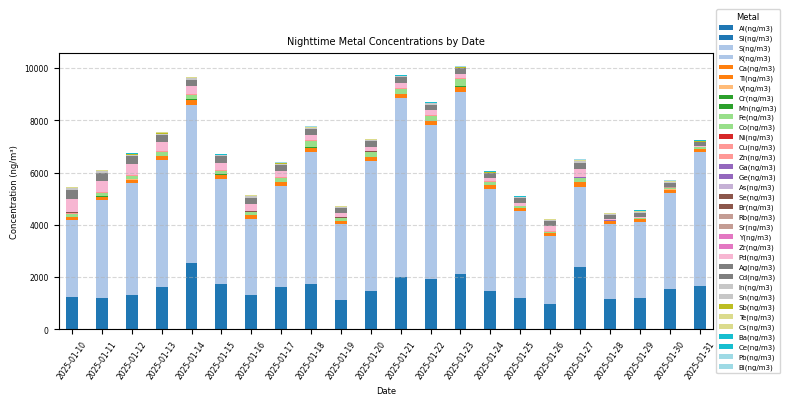

In [23]:
# Nighttime 누적 막대 그래프
plt.figure(figsize=(10, 6))  # 전체 그래프 크기 설정

df_night.set_index('Date')[metal_columns].plot(
    kind='bar', # 막대 그래프
    stacked=True, # 누적 그래프 설정
    figsize=(8, 4),
    width=0.4, # 막대 너비 설정
    colormap='tab20')  # 컬러맵 설정

# 그래프 기본 설정
plt.title("Nighttime Metal Concentrations by Date", fontsize=7)
plt.xlabel("Date", fontsize=6)
plt.ylabel("Concentration (ng/m³)", fontsize=6)
plt.xticks(rotation=55, fontsize=5.5)
plt.yticks(fontsize=5.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 범례 설정
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5),
           fontsize=5,
           title='Metal',
           title_fontsize=6)

# 레이아웃 자동 조절
plt.tight_layout()

# 결과 출력
plt.show()